# Importing libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# Loading Data

In [69]:
df = pd.read_csv('/kaggle/input/elecdataaa/Electric_Vehicle_Population_Data.csv')
# Updated dataset'/kaggle/input/datasetev/ElectricCarData_Clean.csv')

# Display first 5 rows
df.head()


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10


# PreProcessing Data

In [70]:
# Check basic information
df.info()
# Summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235692 entries, 0 to 235691
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         235692 non-null  object 
 1   County                                             235689 non-null  object 
 2   City                                               235689 non-null  object 
 3   State                                              235692 non-null  object 
 4   Postal Code                                        235689 non-null  float64
 5   Model Year                                         235692 non-null  int64  
 6   Make                                               235692 non-null  object 
 7   Model                                              235692 non-null  object 
 8   Electric Vehicle Type                              235692 non-null  object

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,235689.000000,235692.000000,235656.000000,235656.000000,235198.000000,2.356920e+05,2.356890e+05
mean,98177.656463,2021.406658,46.262569,787.268328,28.879519,2.353127e+08,5.298066e+10
std,2524.218661,2.991908,84.045829,7177.668305,14.904644,6.799098e+07,1.521066e+09
min,1731.000000,2000.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2020.000000,0.000000,0.000000,17.000000,2.053457e+08,5.303301e+10
50%,98126.000000,2023.000000,0.000000,0.000000,32.000000,2.522795e+08,5.303303e+10
75%,98374.000000,2024.000000,38.000000,0.000000,42.000000,2.696401e+08,5.305307e+10
max,99577.000000,2025.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.602100e+10


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])


Missing values per column:
 County                    3
City                      3
Postal Code               3
Electric Range           36
Base MSRP                36
Legislative District    494
Vehicle Location         10
Electric Utility          3
2020 Census Tract         3
dtype: int64


In [71]:
# Fill missing numerical values with the median
df["Electric Range"] = df["Electric Range"].fillna(df["Electric Range"].median())
df["Base MSRP"] = df["Base MSRP"].fillna(df["Base MSRP"].median())

# Drop rows with missing categorical values
df = df.dropna(subset=["County", "City", "State", "Electric Utility"])




In [72]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
categorical_cols = ["County", "City", "State", "Make", "Model", "Electric Vehicle Type", 
                    "Clean Alternative Fuel Vehicle (CAFV) Eligibility", "Electric Utility"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use


# Removing Outliers

In [73]:
# Define numerical columns
numerical_cols = ["Model Year", "Electric Range", "Base MSRP"]

# Remove outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# Visualization & Analytics

<Figure size 1000x500 with 0 Axes>

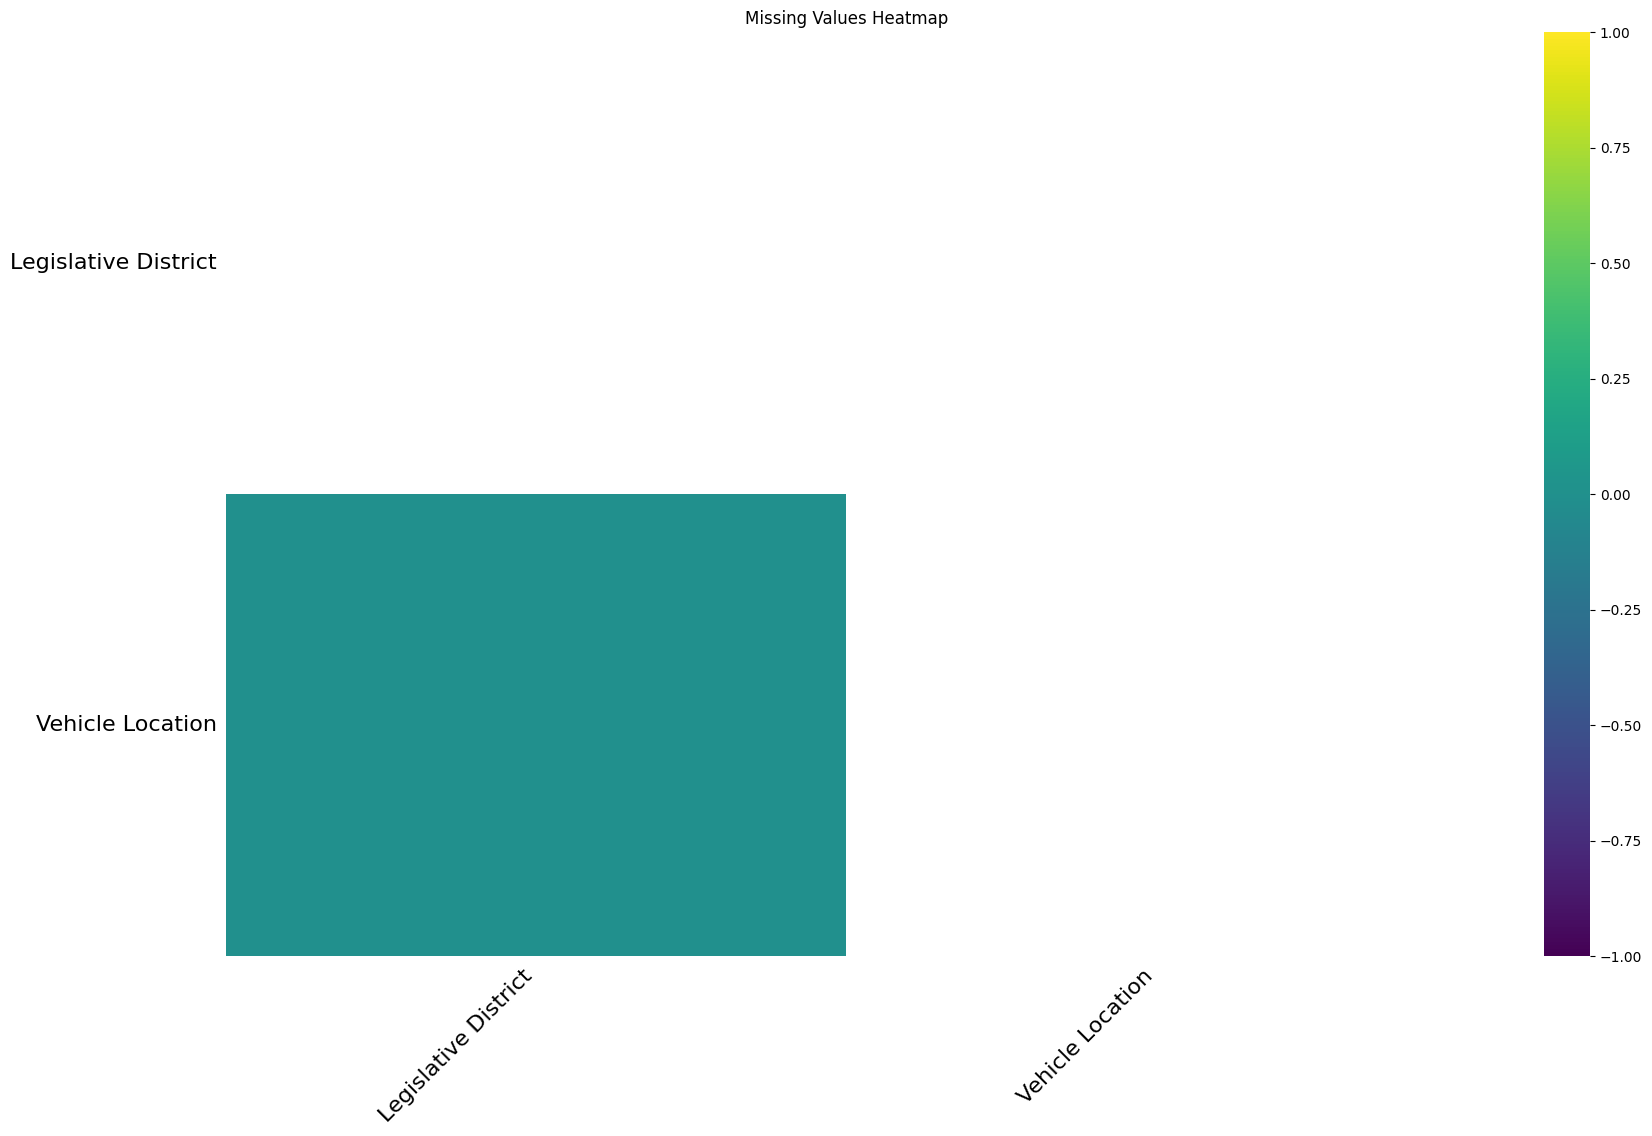

In [74]:
import missingno as msno

plt.figure(figsize=(10, 5))
msno.heatmap(df, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [58]:
print(df.columns)


Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')


In [75]:
print(df['Model Year'][:10])

2     2023
3     2021
4     2023
6     2017
7     2022
10    2014
12    2019
16    2016
17    2015
18    2022
Name: Model Year, dtype: int64


# Trend Analysis of EV Adoption Over Time

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


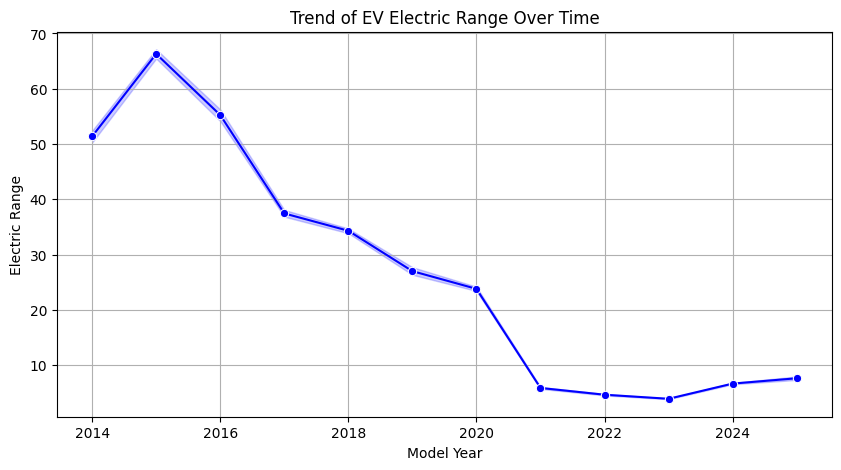

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Model Year', y='Electric Range', marker='o', color='b')
plt.title("Trend of EV Electric Range Over Time")
plt.xlabel("Model Year")
plt.ylabel("Electric Range")
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


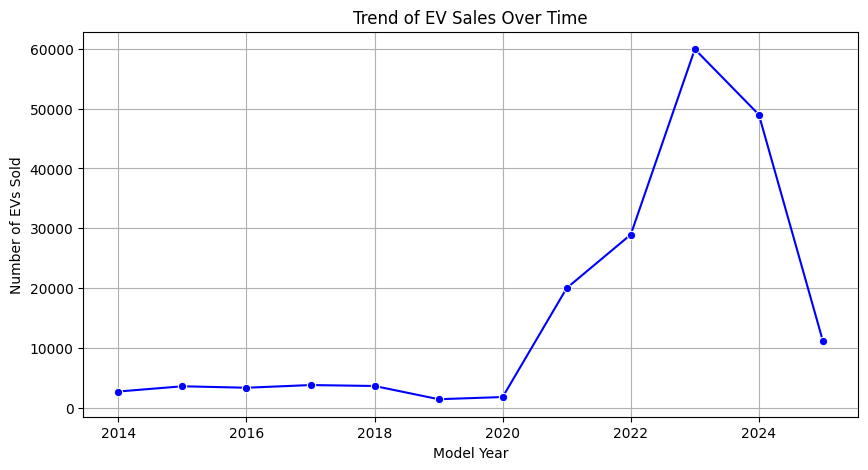

In [77]:
ev_sales_by_year = df.groupby('Model Year').size().reset_index(name='EV Sales')

plt.figure(figsize=(10, 5))
sns.lineplot(data=ev_sales_by_year, x='Model Year', y='EV Sales', marker='o', color='b')
plt.title("Trend of EV Sales Over Time")
plt.xlabel("Model Year")
plt.ylabel("Number of EVs Sold")
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


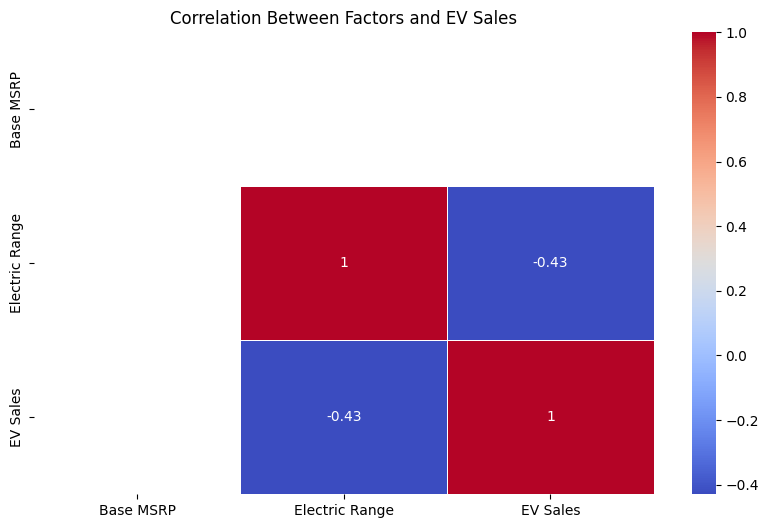

In [78]:
import numpy as np

# Select key influencing factors
factors = ["Base MSRP", "Electric Range"]
df["EV Sales"] = df.groupby("Model Year")["Model Year"].transform("count")  

# Pairwise correlation with EV Sales
correlations = df[factors + ["EV Sales"]].corr()

# Heatmap of correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Factors and EV Sales")
plt.show()


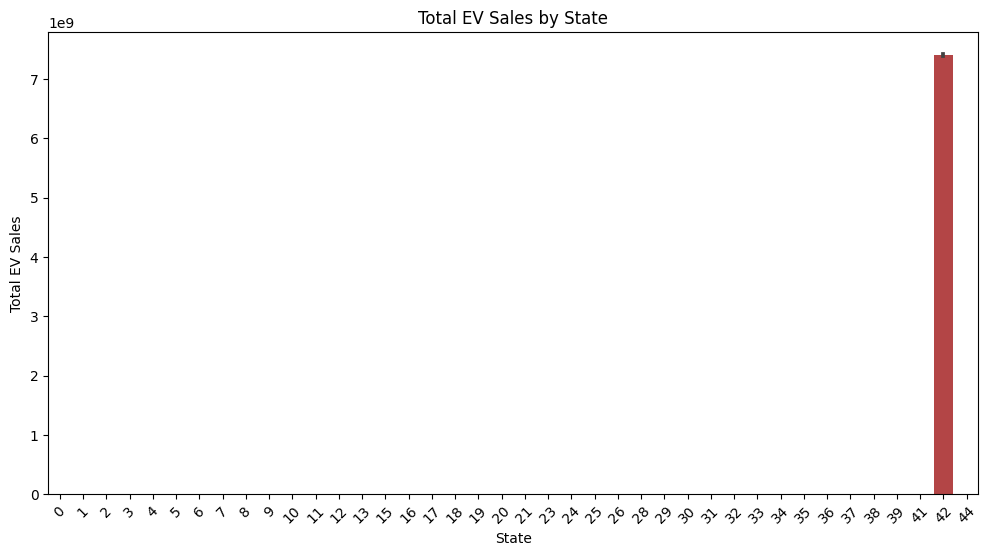

In [79]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="State", y="EV Sales", estimator=sum, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Total EV Sales by State")
plt.xlabel("State")
plt.ylabel("Total EV Sales")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


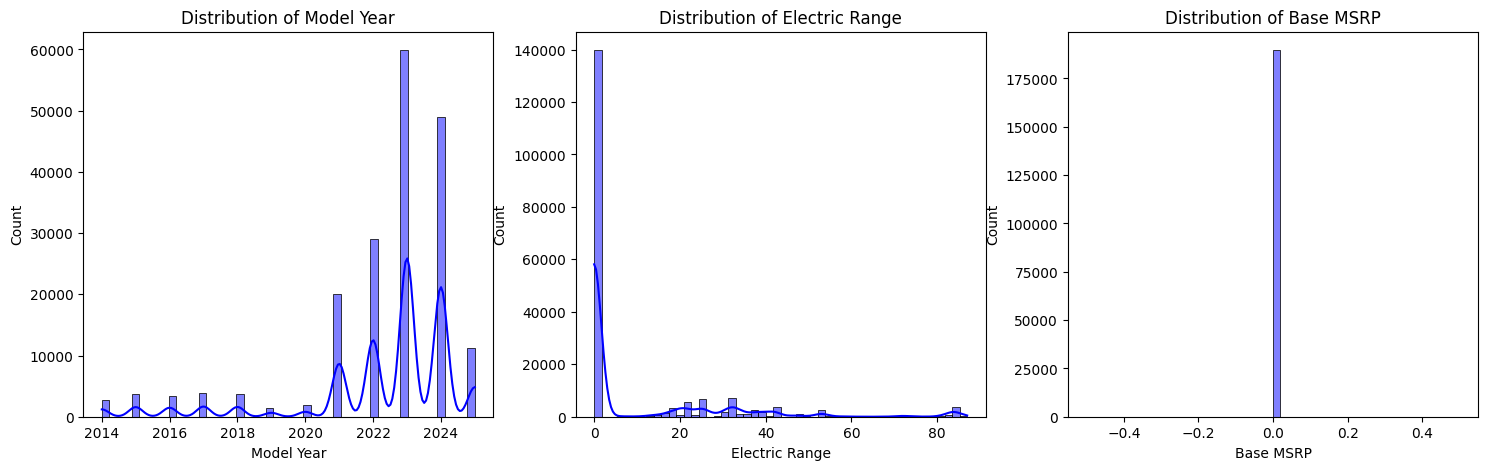

In [80]:
numerical_cols = ["Model Year", "Electric Range", "Base MSRP"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")

plt.show()


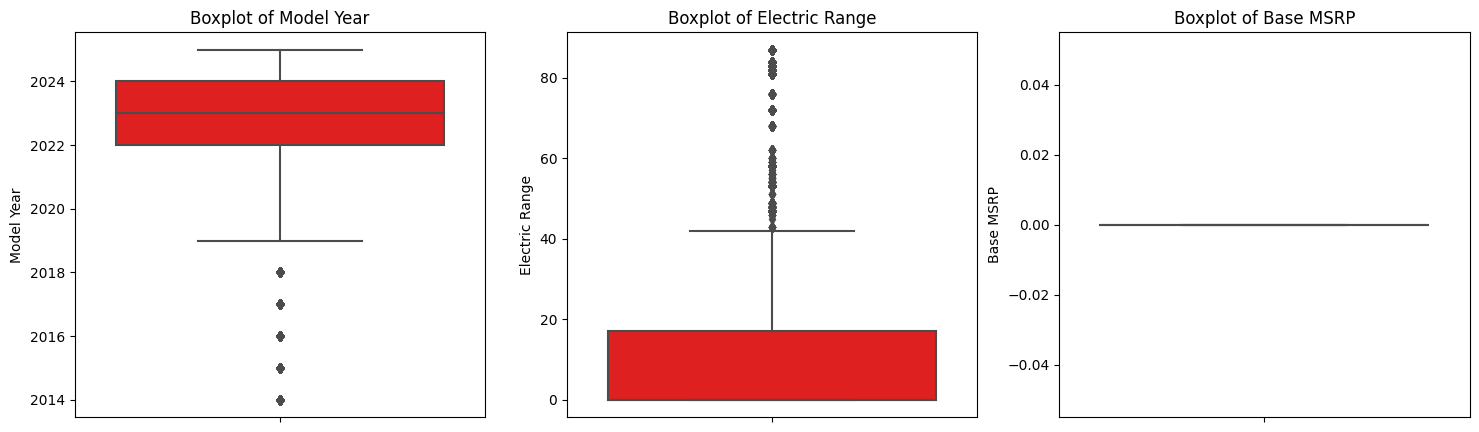

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="red")
    axes[i].set_title(f"Boxplot of {col}")

plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


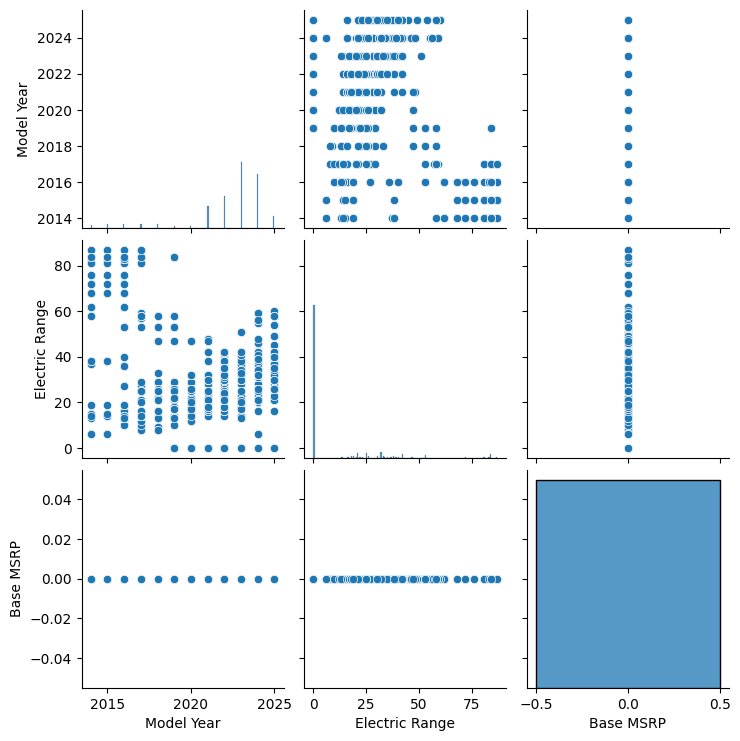

In [82]:
sns.pairplot(df[numerical_cols])
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


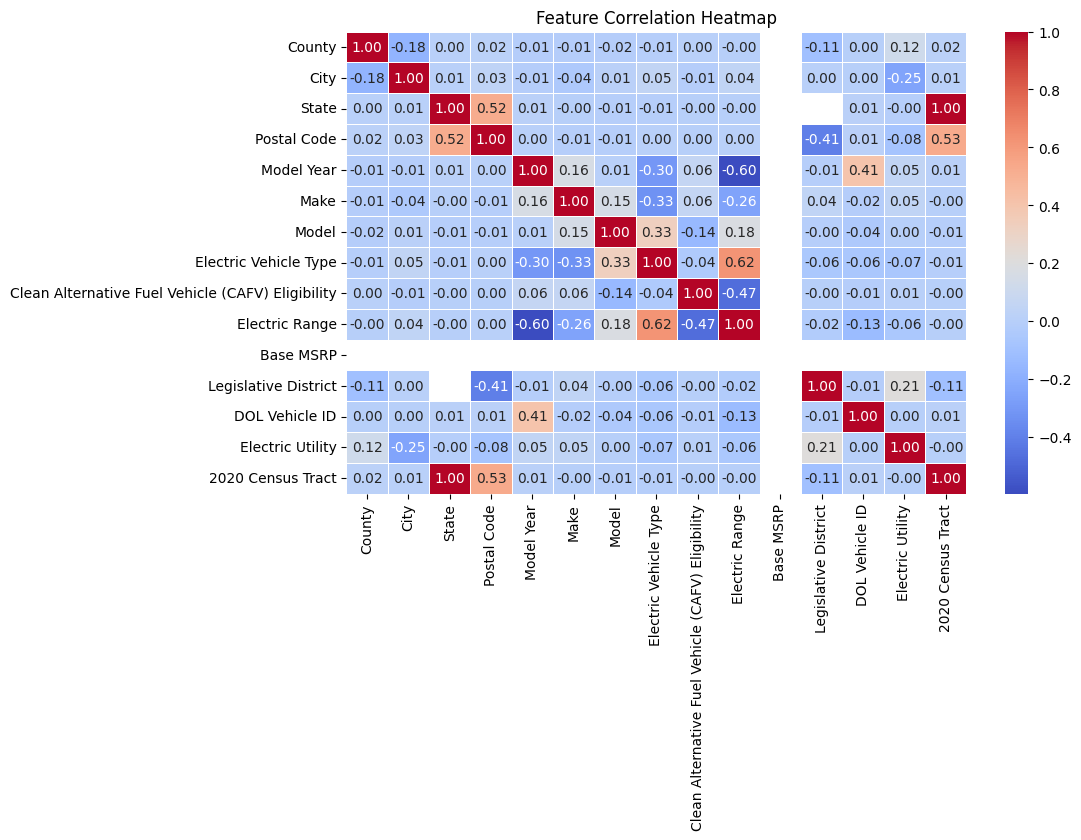

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


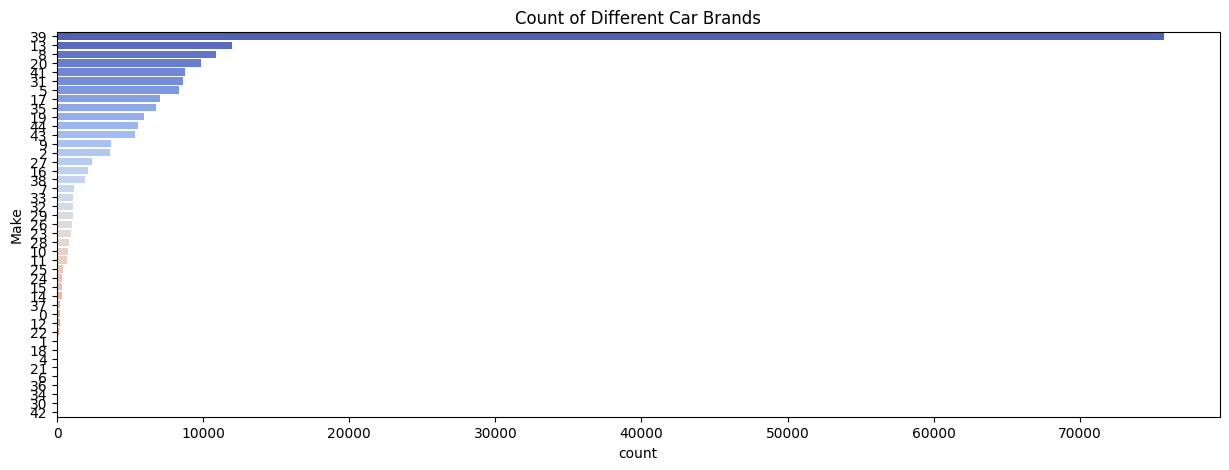

In [15]:
plt.figure(figsize=(15, 5))
sns.countplot(y=df["Make"], order=df["Make"].value_counts().index, palette="coolwarm")
plt.title("Count of Different Car Brands")
plt.show()


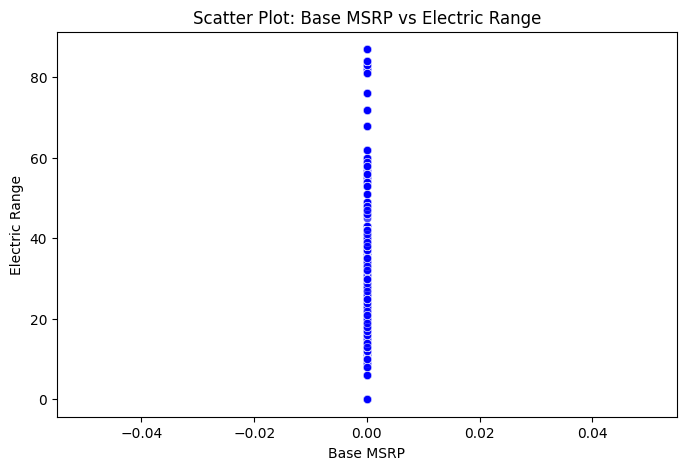

In [83]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Base MSRP"], y=df["Electric Range"], alpha=0.7, color="blue")
plt.title("Scatter Plot: Base MSRP vs Electric Range")
plt.xlabel("Base MSRP")
plt.ylabel("Electric Range")
plt.show()


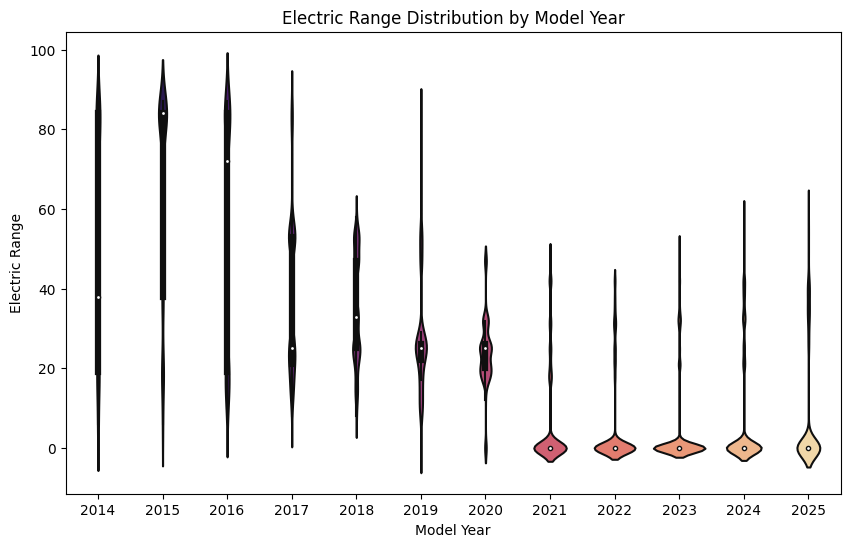

In [84]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=df["Model Year"], y=df["Electric Range"], palette="magma")
plt.title("Electric Range Distribution by Model Year")
plt.show()


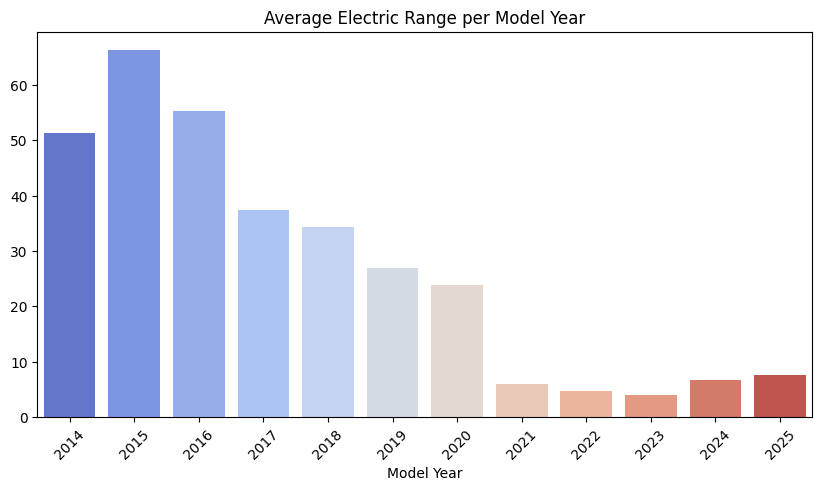

In [85]:
avg_range_per_year = df.groupby("Model Year")["Electric Range"].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_range_per_year.index, y=avg_range_per_year.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Average Electric Range per Model Year")
plt.show()


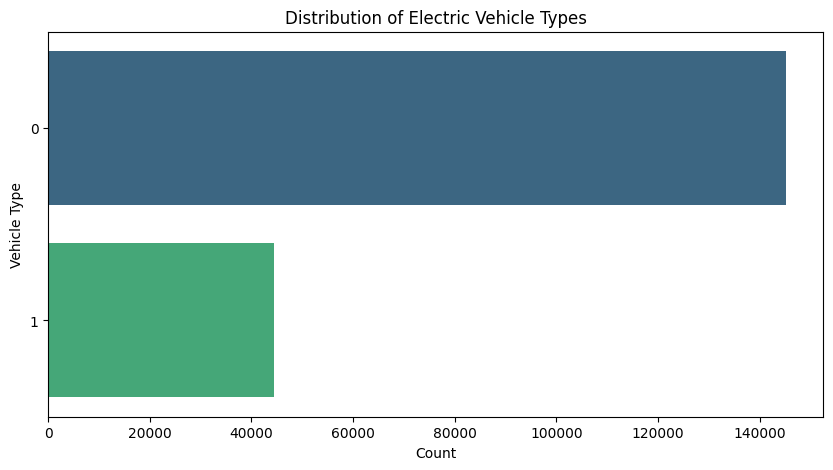

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["Electric Vehicle Type"], order=df["Electric Vehicle Type"].value_counts().index, palette="viridis")
plt.title("Distribution of Electric Vehicle Types")
plt.xlabel("Count")
plt.ylabel("Vehicle Type")
plt.show()


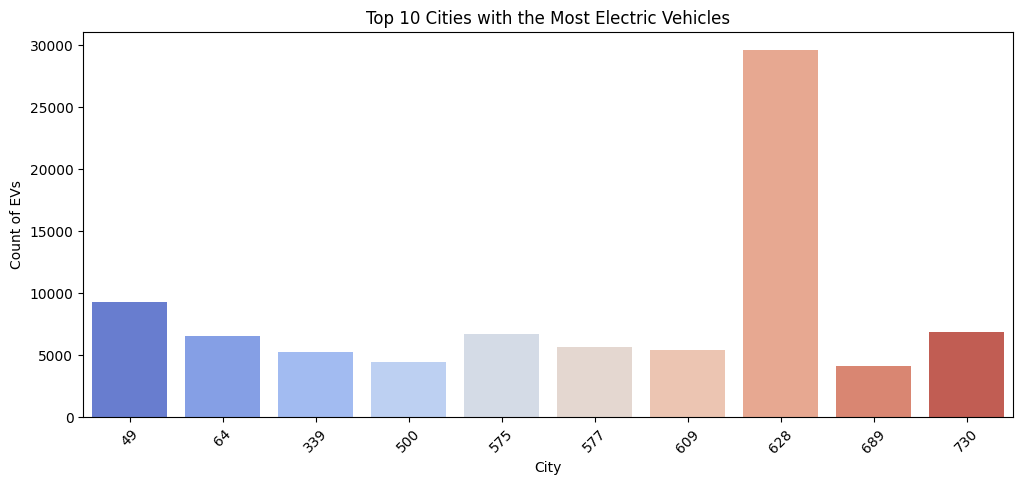

In [86]:
top_cities = df["City"].value_counts().nlargest(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Cities with the Most Electric Vehicles")
plt.xlabel("City")
plt.ylabel("Count of EVs")
plt.show()


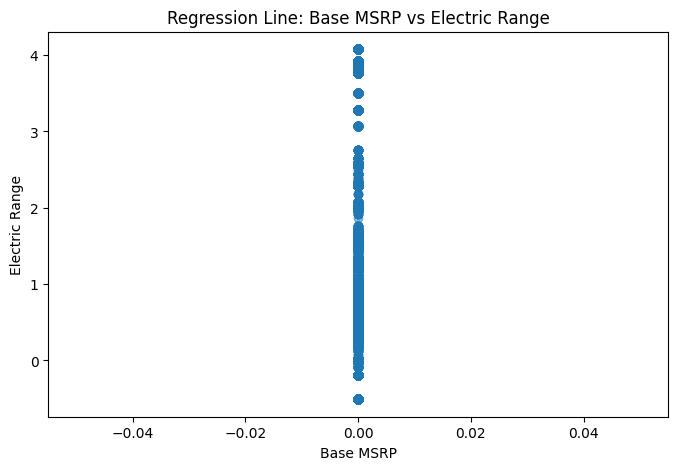

In [21]:
plt.figure(figsize=(8, 5))
sns.regplot(x=df["Base MSRP"], y=df["Electric Range"], scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title("Regression Line: Base MSRP vs Electric Range")
plt.xlabel("Base MSRP")
plt.ylabel("Electric Range")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


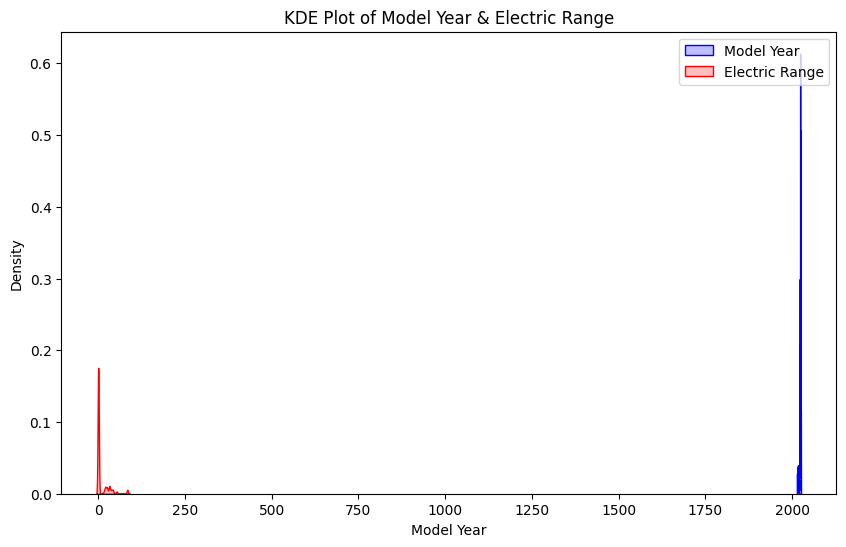

In [87]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df["Model Year"], label="Model Year", fill=True, color="blue")
sns.kdeplot(df["Electric Range"], label="Electric Range", fill=True, color="red")
plt.title("KDE Plot of Model Year & Electric Range")
plt.legend()
plt.show()


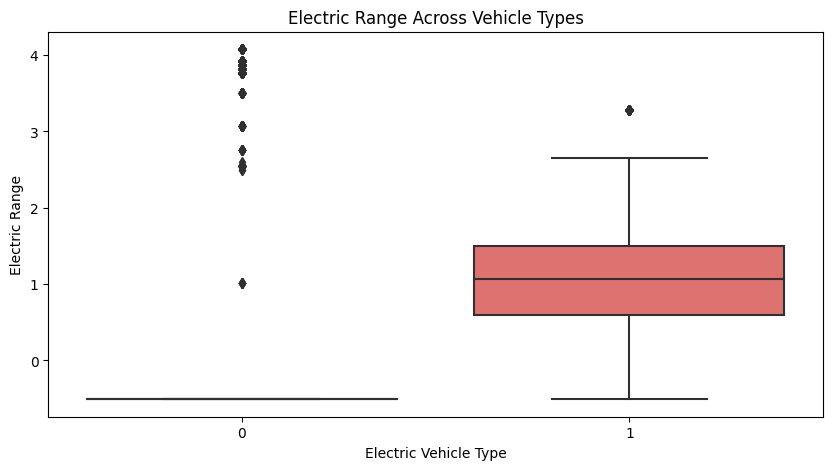

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Electric Vehicle Type"], y=df["Electric Range"], palette="magma")
plt.title("Electric Range Across Vehicle Types")
plt.show()


Skewness Values:
 Model Year       -1.896425
Electric Range    2.236575
Base MSRP              NaN
dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

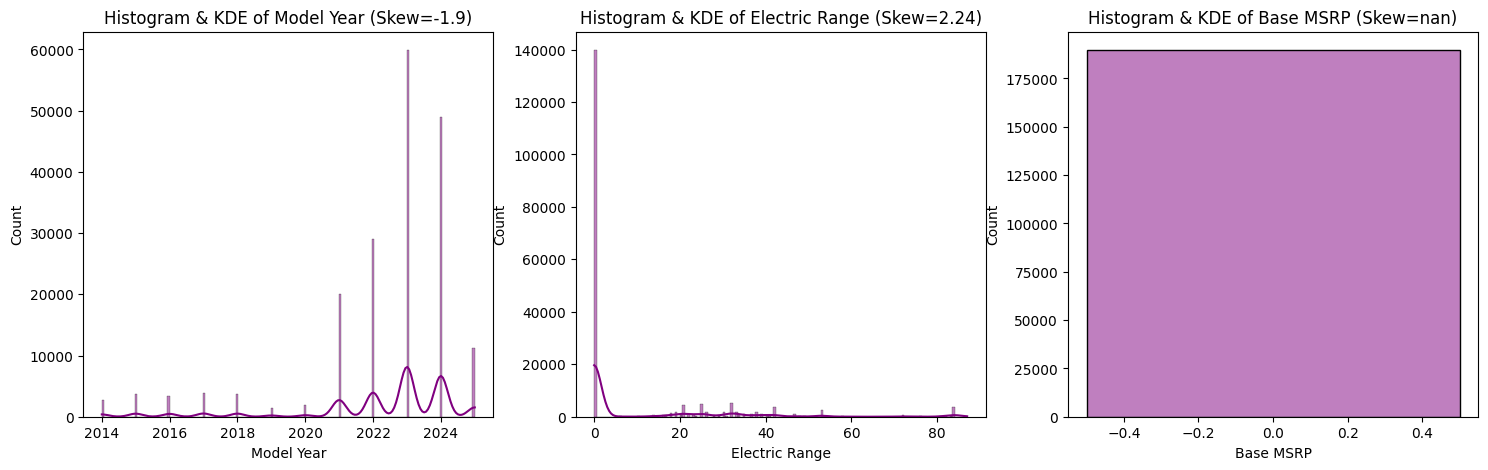

In [88]:
from scipy.stats import skew

# Compute skewness
skew_vals = df[numerical_cols].apply(skew)
print("Skewness Values:\n", skew_vals)

# Plot histogram & KDE for skewed features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="purple")
    axes[i].set_title(f"Histogram & KDE of {col} (Skew={round(skew_vals[col], 2)})")

plt.show()

# Model Development

# Importing libraries 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [26]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target Variable (y)
X = df.drop("Electric Range", axis=1)  # Predicting 'Electric Range'
y = df["Electric Range"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Done")


Train-Test Split Done


In [29]:
# Identify columns that are not numeric (int or float)
non_numeric_columns = X_train.select_dtypes(exclude=['int64', 'float64']).columns

# Print results
if non_numeric_columns.empty:
    print("All columns are numeric.")
else:
    print("Columns with non-numeric values:", list(non_numeric_columns))


Columns with non-numeric values: ['VIN (1-10)', 'Vehicle Location']


# Transforming Data

In [31]:
# Label encoding using factorize to handle unseen labels
for col in ['VIN (1-10)', 'Vehicle Location']:
    # Factorize returns two outputs: the encoded array and unique labels, we only use the first
    X_train[col], unique = pd.factorize(X_train[col])

    # Apply the mapping from train to test, unknown values will be assigned -1
    X_test[col] = X_test[col].map({val: i for i, val in enumerate(unique)}).fillna(-1).astype(int)

print("Categorical columns successfully encoded using factorization.")


Categorical columns successfully encoded using factorization.


In [33]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoders
encoders = {}

for col in ['VIN (1-10)', 'Vehicle Location']:
    # Fit LabelEncoder on training data
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

    # Store mapping of category to encoded value
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    # Transform test set, mapping unseen values to -1
    X_test[col] = X_test[col].map(encoders[col]).fillna(-1).astype(int)

print("Categorical columns successfully label-encoded.")


Categorical columns successfully label-encoded.


# Feature Scaling

In [34]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling only on numerical columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Making Target variable

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Display the shape of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Linear Regression Model

In [39]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Ensure corresponding labels remain

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]  # Ensure corresponding labels remain


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.4f}, R2 Score: {r2_lr:.4f}")


Linear Regression - MSE: 0.2364, R2 Score: 0.7566


In [41]:
target = "Electric Range"  # Define the target variable
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Done")


Train-Test Split Done


# Random Forest Regressor

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Ensure target variable is defined
target = 'Electric Range'  # Replace with the actual target column name

# Split features and target
X = df.drop(columns=[target])
y = df[target]

# Handle missing values before splitting
X.fillna(method='ffill', inplace=True)
y.fillna(y.mean(), inplace=True)

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numeric transformation
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

# Categorical transformation with unseen category handling
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Model
model = LinearRegression()

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

print("Pipeline training and prediction completed!")


<ipython-input-46-4ff080585559>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)


Pipeline training and prediction completed!


In [47]:
# Predict on test data
y_pred = pipeline.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")


Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.24
Root Mean Squared Error (RMSE): 0.49
R-squared (R2 Score): 0.76


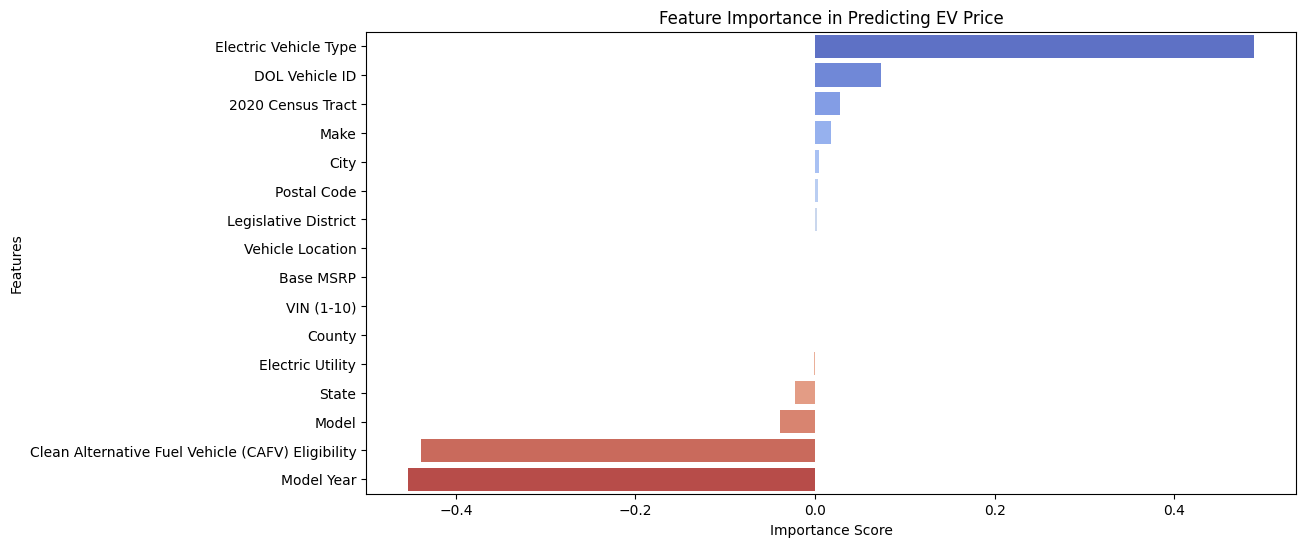

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numerical feature names are in list format
num_feature_names = list(num_features)

# Extract categorical feature names
cat_feature_names = list(cat_features) 

# Combine all feature names
feature_names = num_feature_names + cat_feature_names

# Extract feature importance using coefficients
feature_importance = model.coef_

if len(feature_importance) != len(feature_names):
    print(f"Feature importance length ({len(feature_importance)}) does not match feature names length ({len(feature_names)})")
else:
    # Create DataFrame for visualization
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feat_imp_df['Importance'], y=feat_imp_df['Feature'], palette="coolwarm")
    plt.title("Feature Importance in Predicting EV Price")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()


                        MAE       MSE      RMSE  R2 Score
Linear Regression  0.291971  0.235720  0.485510  0.757380
Random Forest      0.002105  0.001865  0.043184  0.998081
Gradient Boosting  0.021816  0.004806  0.069324  0.995054
XGBoost            0.002266  0.000706  0.026572  0.999273


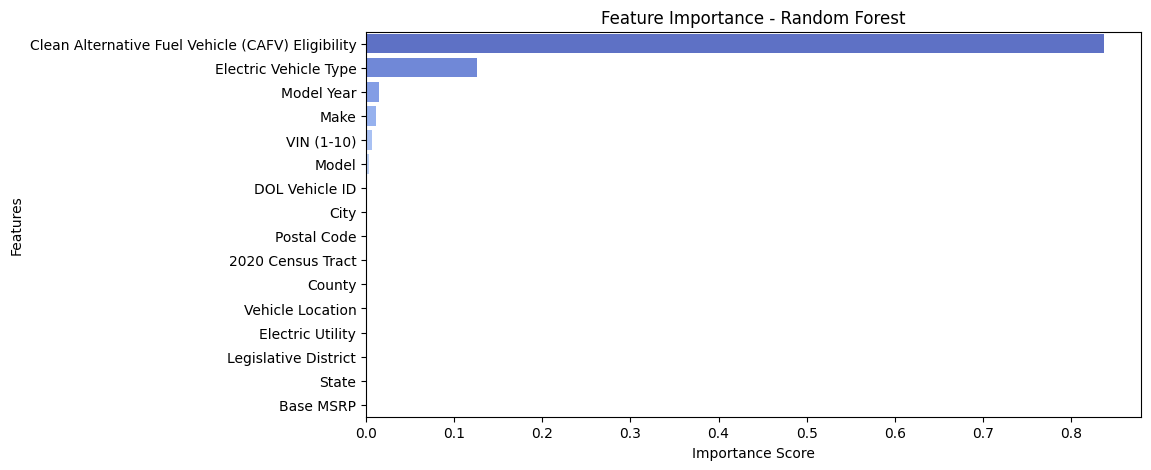

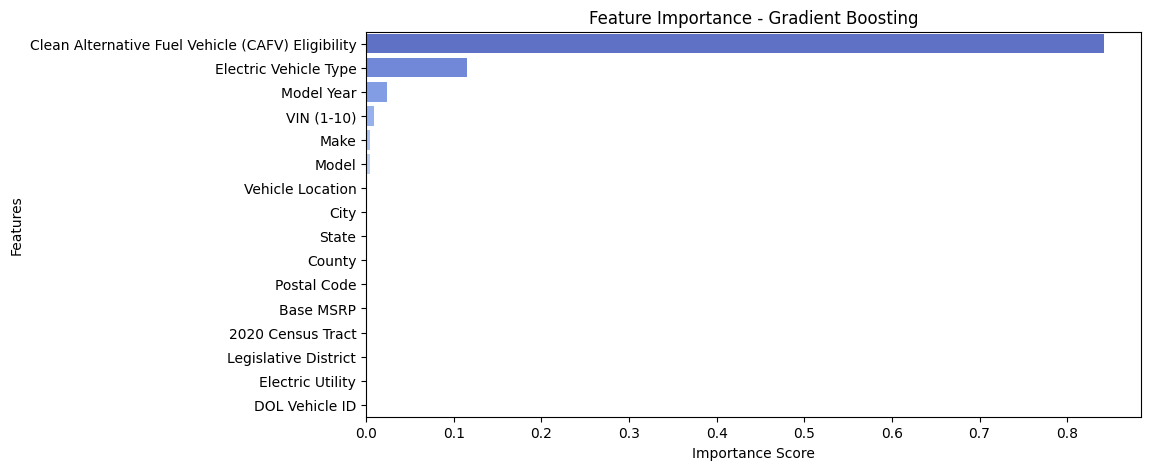

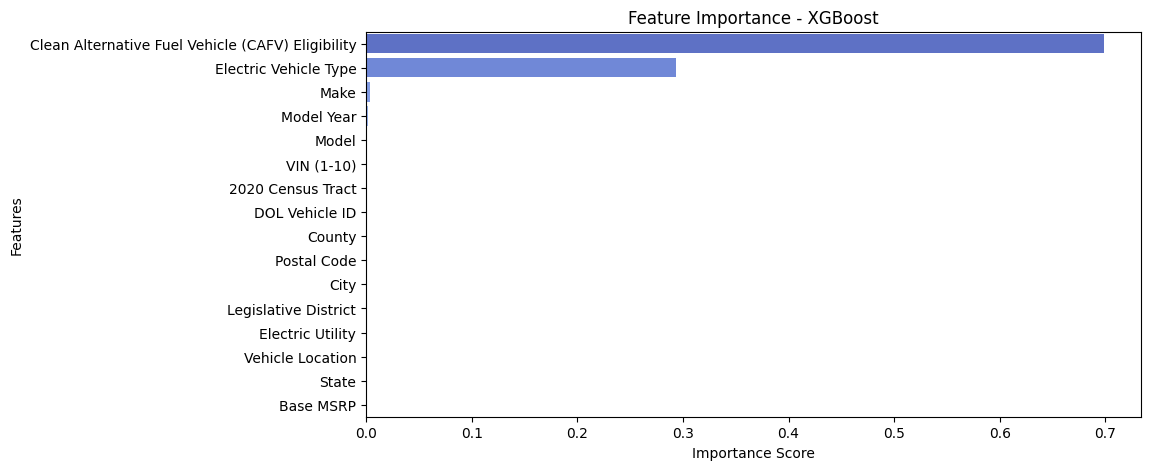

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Identify numerical and categorical features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipelines
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}
feature_importance = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
    
    # Feature importance extraction for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importance[name] = model.feature_importances_

# Print results
results_df = pd.DataFrame(results).T
print(results_df)

# Plot feature importance for tree-based models
for name, importance in feature_importance.items():
    feature_names = num_features + cat_features
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feat_imp_df['Importance'], y=feat_imp_df['Feature'], palette="coolwarm")
    plt.title(f"Feature Importance - {name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()


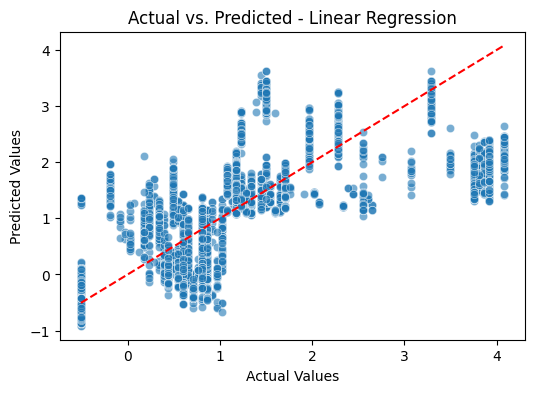

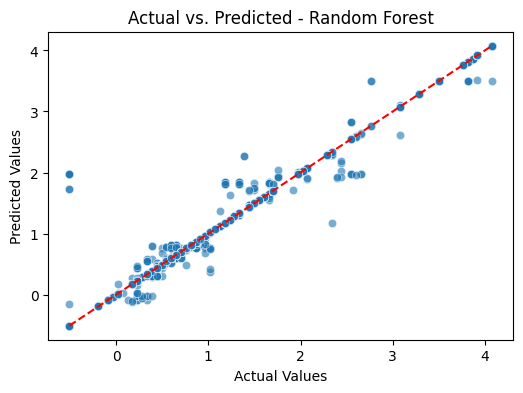

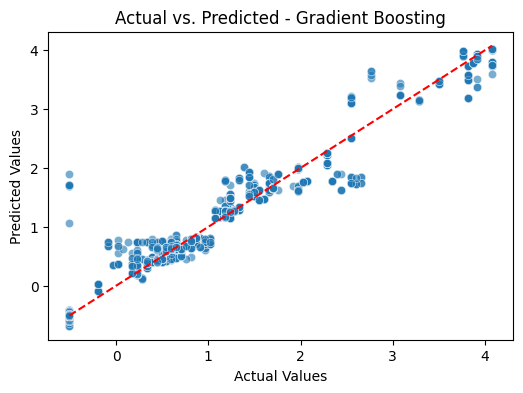

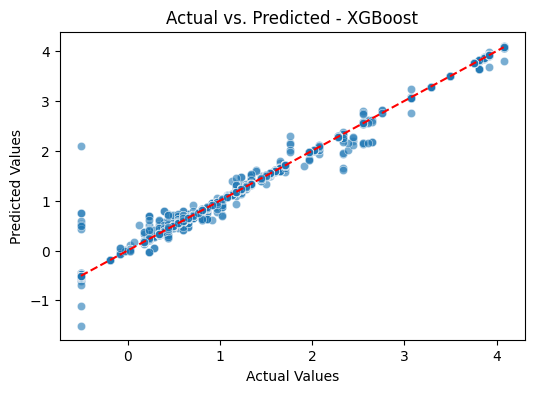

Model Evaluation Results:
                         MAE       MSE      RMSE  R² Score
Linear Regression  0.291971  0.235720  0.485510  0.757380
Random Forest      0.002105  0.001865  0.043184  0.998081
Gradient Boosting  0.021816  0.004806  0.069324  0.995054
XGBoost            0.002266  0.000706  0.026572  0.999273

 Best Model: XGBoost (Lowest RMSE)


In [56]:
# Dictionary to store evaluation metrics
evaluation_results = {}

# Test and evaluate each trained model
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    evaluation_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R² Score": r2}
    
    # Plot actual vs predicted values
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Perfect fit line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted - {name}")
    plt.show()

# Convert results to DataFrame
evaluation_df = pd.DataFrame(evaluation_results).T
print("Model Evaluation Results:\n", evaluation_df)

# Display the best model based on RMSE
best_model = evaluation_df['RMSE'].idxmin()
print(f"\n Best Model: {best_model} (Lowest RMSE)")
